## gac params

b: bucket size (limits scope of the GAC clustering)
p: reduction factor (i.e 100 clusters becomes 50 clusters)
s: min similarity threshold (for two clusters to be combined)
t: number of terms to keep per cluster prototype
term weighting: how to vectorize (i.e "ltc", from SMART weighting scheme)
re: # of iterations between re-clustering 

Input: Sorted stories + Params
Output: Forest of binary tree clusters

### basic gac - greedy, bottom-up

n_clus_init = parition size


repeat until most similar < s or n_clus > n_clus_init/p
    - linkage
    - clusters
    - average centroids and timestamps

### temporal gac

- sort stories
- let sort be initial partition
- repeat until most similar < s or n_clus < b 
    - re-bucketing
    - `if i % k == 0 && i != 0`
        - apply gac to all clusters
    - else
        - divide partition into 'b' buckets (non-overlapping and consecutive)
        - apply gac to each bucket
        - remove bucket boundaries
    



In [1]:
import json
import operator
import itertools
import pandas as pd
import scipy as sp
import numpy as np
from scipy.sparse import csr_matrix
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import fcluster
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import MeanShift, estimate_bandwidth

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
%matplotlib inline
#cophenet test
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

In [3]:
#library functions
def reduce_and_plot_clusters(X, model, title=""):
    X_reduced = TruncatedSVD().fit_transform(X)
    X_embedded = TSNE(learning_rate=100).fit_transform(X_reduced)

    n_clus = len(set(model.labels_.tolist()))

    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker="x",
                c=model.labels_.tolist(), cmap=plt.cm.get_cmap("jet", n_clus))
    plt.colorbar(ticks=range(n_clus))
    plt.clim(-0.5, (n_clus - 0.5))
    plt.savefig('i/reduce_and_plot_clusters' +
                str(datetime.now()) + '.png')
    plt.show()

    
# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
#             x = i
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
            
    plt.show()
    
    return ddata

## Read Data

In [4]:
file_num = [35]
# file_num = [35]

data = []
for f in file_num: 
    print f
    with open("../datasets/raw-data/"+str(f)+".json", 'rb') as infile:
        data.extend(json.load(infile))
        
print len(data)

35
23


# pre-process (entities)

In [18]:
# stories = [doc["_source"]["content"] for doc in data]
# times = [doc]
# ids = [doc["_id"] for doc in data]

def format_entities(norm_ent):
    ents = []
    for ent in norm_ent:
        try:
            ents.append(ent['surface-form'])
        except:
            continue
    return " ".join(ents)

d = [{"id": doc["_id"],
  "first-published": doc["_source"]["first-published"],
  "title": doc["_source"]["title"],
  "summary": doc["_source"]["title"],
  "content": doc["_source"]["content"],
  "entities": format_entities(doc["_source"]["normalised-entities"])} for doc in data]

df_story = pd.DataFrame(d)

df_story['first-published-epoch'] = df_story['first-published'].apply(lambda x : int(datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ").strftime("%s")))
df_story = df_story.sort_values(by='first-published-epoch')
df_story = df_story.reset_index(drop=True)

In [19]:
vect = TfidfVectorizer(use_idf=True, norm='l2', sublinear_tf=True)
vsm = vect.fit_transform(df_story["content"].values)

# original
vsm_arr = vsm.toarray()
# vsm_arr = vsm.todense()

df_story['vsm'] = [r for r in vsm_arr]

# def gac

In [20]:
df_story.head()

,content,entities,first-published,id,summary,title,first-published-epoch,vsm
0,Partners Group has been investing in real esta...,Partners Group Zug Norway,2015-08-31T00:00:00Z,2e021cc0-8589-4e33-9ec9-357f0ab3e099,Partners: Non-traditional RE secondary deals o...,Partners: Non-traditional RE secondary deals o...,1440975600,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Partners Group anticipates secondaries pricing...,Partners Group,2015-08-31T00:00:00Z,225f3ef1-88be-41b4-8aab-3e12b42aef83,"Partners Group cautious on PE, overweight RE i...","Partners Group cautious on PE, overweight RE i...",1440975600,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06352106..."
2,"AP3, Sweden's third national pension fund, has...",Sweden Eskilstuna Halmstad Karlskrona Swedish ...,2015-09-02T00:00:00Z,ccaf4766-12ce-401e-aae2-1c1d2b81b82b,"AP3 enters office, retail property joint ventu...","AP3 enters office, retail property joint ventu...",1441148400,"[0.0, 0.0, 0.0700093521307, 0.0, 0.0, 0.0, 0.0..."
3,"Sveafastigheter, which is part of Brunswick Re...",Partners Group Nordic Brunswick Sweden Finland...,2015-09-02T00:00:00Z,4a23c921-c6a7-4bde-9ea9-c260542cb71e,Partners Group buys Nordic real estate portfolio,Partners Group buys Nordic real estate portfolio,1441148400,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,The Swiss private markets investment manager h...,Partners Group Nordic Swiss,2015-09-02T00:00:00Z,94a8cbfa-cd77-4654-a701-8412d7598551,Partners Group buys Nordic real estate portfolio,Partners Group buys Nordic real estate portfolio,1441148400,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## GAC (with stopping critera)

In [21]:
# util

# GAC Model
def mycosine(x1, x2):
    x1 = x1.reshape(1,-1)
    x2 = x2.reshape(1,-1)
    ans = 1 - cosine_similarity(x1, x2)
    return max(ans[0][0], 0)

def get_linkage_matrix(vsm):
    Z = linkage(vsm, method='average', metric=mycosine)
    c, coph_dists = cophenet(Z, pdist(vsm))
    print "cophenet test: ", c
    return Z

def get_cluster_size(vsm, Z):
    n = vsm.shape[0]
    for i, z in enumerate(Z):
#         print i, z
        if z[2] > 0.8 :
            print i, ": Min similarity reached"
            print "Z values"
            print Z[i - 1]
            n_clus = n - (i + 1) + 1
            break
        if n * 0.5 > n - (i + 1):
            print i, ": Max reduction reached"
            print "Z values"
            print Z[i - 1]
            n_clus = n - (i + 1) + 1
            break
            
    print "n_clus", n_clus
            
    return n_clus

def get_clusters(Z, n_clus, criterion='maxclust'):
    clusters = fcluster(Z, n_clus, criterion='maxclust')

In [22]:
# tunable params

b = (400 / 15836) * df_story.shape[0]
p = 0.5
s = 0.2
t = 100
# term weighting = "ltc" # possible through sklearn
re = 5

In [23]:
# reconsturct vsm: reconstruct np.ndarray from pd.Series
def recon_vsm(vsm_series):
    rows = vsm_series.shape[0]
    cols = vsm_series[0].shape[0]
    print "[EDEN I/O -- recon_vsm] (rows,cols): ", rows, cols
    vsm = np.zeros((rows, cols))

    for i, r in enumerate(vsm_series):
        vsm[i] = r

    # print "[EDEN I/O -- recon_vsm] vsm shape: ", vsm.shape
    # print "[EDEN I/O -- recon_vsm] vsm type: ", type(vsm)
    # print "[EDEN I/O -- recon_vsm] vsm[0] type: ", type(vsm[0])

    return vsm

# creation dictionary and lists of ordering of clustering
# from linkage matrix
# anatomy of z: z[0] - first doc, z[1] - second doc
# returns dict: key - doc, value - order
def get_cluster_order(Z):
    cluster_order_dict = {}
    cluster_order_list = []
    for i, z in enumerate(Z):
        # create pairs based on order
        print 2*i, z[0]
        print 2*i+1, z[1]
        cluster_order_dict[z[0]] = 2 * i
        cluster_order_dict[z[1]] = 2 * i + 1
        # add docs to list
        cluster_order_list.extend([z[0], z[1]])
    
    return [cluster_order_dict, cluster_order_list]

# build centroid
def build_centroids(group):
    idx = group.index.values
    print "name: ", group.name, "group len: ", len(group), "IDX: ", idx
    # if not singleton (incrementally average vectors and timestamps)
    if len(group) == 1:
        print type(group)
        return group
    else:
        # get idx, order and associated (id, time, vsm vectors)

        order = [cluster_order_dict[i] for i in idx] 
        idx_order = sorted(zip(idx, order), key=lambda x: x[1])
        idx_order = [list(el) for el in idx_order]
        id_vector = [group.loc[i[0]]['id'] for i in idx_order]
        time_vector = [group.loc[i[0]]['first-published-epoch'] for i in idx_order]
        vsm_vector = [group.loc[i[0]]['vsm'] for i in idx_order]
    
        # debug
        print "BEFORE PROCESSING"
        print "idx_order: ", idx_order
        print "id_vector: ", id_vector
        print "time_vector: ", time_vector
        print "vsm_vector: ", vsm_vector
        
        # pair immediate pairs i, j, where j = i+1
        # and update vectors
        for i, el in enumerate(idx_order):
            if i + 1 < len(idx_order):
                j = i + 1
                if idx_order[i][1] == idx_order[j][1] - 1:
#                     print "pair found: ", idx_order[i][0], idx_order[j][0]

                    # update idx_order
                    idx_order[i][0] = [idx_order[i][0], idx_order[j][0]]
                    idx_order[i][1] = np.mean([idx_order[i][1], idx_order[j][1]]) 
                    idx_order.pop(j)
                    
                    # update id_vector
                    id_vector[i] = [id_vector[i], id_vector[j]]
                    id_vector.pop(j)
                    
                    # update time_vector
                    time_vector[i] = np.mean([time_vector[i], time_vector[j]])
                    time_vector.pop(j)
                    
                    # update vsm_vector
                    vsm_vector[i] = np.mean(np.array([vsm_vector[i], vsm_vector[j]]), axis=0)
                    vsm_vector.pop(j)
             
        print
        
        i = 0
        j = 1
        
        # Merge remaining clusters in order
        # and update vectors
        while len(idx_order) > 1:
#             print "merge pair: ", idx_order[i][0], idx_order[j][0]

            # update idx_order
            idx_order[i][0] = [idx_order[i][0], idx_order[j][0]]
            idx_order[i][1] = np.mean([idx_order[i][1], idx_order[j][1]])
            idx_order.pop(j)
            
            # update id_vector
            id_vector[i] = [id_vector[i], id_vector[j]]

            # update time_vector
            time_vector[i] = np.mean([time_vector[i], time_vector[j]])
            time_vector.pop(j)

#             print type(vsm_vector[0]), type(vsm_vector[1])

            vsm_vector[i] = np.mean(np.array([vsm_vector[i], vsm_vector[j]]), axis=0)
            vsm_vector.pop(j)

#             print idx_order        
                    
        # perform remaining averageing
                    
        print "AFTER PROCESSING"
        print "id_vector: ", id_vector
        print "idx_order: ", idx_order
        print "time_vector: ", time_vector
        print "vsm_vector: ", vsm_vector
        
        print
        print
        
        group_columns = group.columns
        df_group = pd.DataFrame(columns = group_columns)
        
        group_data = []
        for col in group_columns:
            if col == 'id':
                group_data.append(id_vector)
            elif col == 'first-published-epoch':
                group_data.append(time_vector[0])
            elif col == 'vsm':
                group_data.append(vsm_vector[0])
            elif col == 'cluster':
                group_data.append(group.name)
            else:
                group_data.append(list(group[col]))
        
        df_group.loc[0] = group_data
        return df_group



# print cluster_order_dict
# print cluster_order_list

In [25]:
Z = get_linkage_matrix(recon_vsm(df_story['vsm']))
n_clus = get_cluster_size(vsm, Z)
clusters = fcluster(Z, n_clus, criterion='maxclust')
df_story['cluster'] = clusters
[cluster_order_dict, cluster_order_list] = get_cluster_order(Z)
print len(df_story)
df_update = df_story.groupby('cluster').apply(build_centroids).reset_index(drop=True)
print len(df_update)

[EDEN I/O -- recon_vsm] (rows,cols):  23 1877
cophenet test:  0.921365598361
11 : Max reduction reached
Z values
[  8.      28.       0.7284   3.    ]
n_clus 12
0 10.0
1 11.0
2 14.0
3 15.0
4 13.0
5 16.0
6 24.0
7 25.0
8 2.0
9 3.0
10 0.0
11 1.0
12 17.0
13 21.0
14 12.0
15 26.0
16 7.0
17 18.0
18 19.0
19 20.0
20 8.0
21 28.0
22 6.0
23 22.0
24 5.0
25 31.0
26 33.0
27 34.0
28 23.0
29 35.0
30 32.0
31 37.0
32 30.0
33 36.0
34 9.0
35 38.0
36 27.0
37 39.0
38 40.0
39 41.0
40 29.0
41 42.0
42 4.0
43 43.0
23
name:  name:  1 group len:  2 IDX:  [17 21]
BEFORE PROCESSING
idx_order:  [[17, 12], [21, 13]]
id_vector:  [u'e0639ade-a8ea-4f6e-8f6c-e7571e941506', u'82a2e56a-39ba-41ca-b87f-fdd583827704']
time_vector:  [1444086000, 1445382000]
vsm_vector:  [array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), array([ 0.,  0.,  0., ...,  0.,  0.,  0.])]

AFTER PROCESSING
id_vector:  [[u'e0639ade-a8ea-4f6e-8f6c-e7571e941506', u'82a2e56a-39ba-41ca-b87f-fdd583827704']]
idx_order:  [[[17, 21], 12.5]]
time_vector:  [1444734000.0

In [26]:
df_update

,content,entities,first-published,id,summary,title,first-published-epoch,vsm,cluster
0,[Partners Group has bought three stakes in a t...,[Partners Group Finnish UK Industri Kapital No...,"[2015-10-06T00:00:00Z, 2015-10-21T00:00:00Z]","[[e0639ade-a8ea-4f6e-8f6c-e7571e941506, 82a2e5...","[Partners buys tail-end IK buyout stakes, Part...","[Partners buys tail-end IK buyout stakes, Part...",1.444734e+09,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0385246302765, 0.0...",1
1,[Real estate secondaries funds are chasing abo...,"[Landmark Partners Partners Group DLJ, Harbour...","[2015-10-12T00:00:00Z, 2015-10-19T00:00:00Z]","[[ce14a151-39a1-4ec0-bb50-039be6b883fc, c02fac...","[Real estate secondaries funds target $2.34bn,...","[Real estate secondaries funds target $2.34bn,...",1.444907e+09,"[0.0, 0.0, 0.0, 0.0749754211087, 0.0, 0.0, 0.0...",2
2,[KKR & Co. is aiming to raise at least $1.5 bi...,[KKR Henry Kravis George Roberts Americas TPG ...,"[2015-09-20T00:00:00Z, 2015-09-21T20:43:21Z]","[[87e2f9b4-d94d-4aee-9f11-edccf38dae0c, ef9ca5...",[KKR said to seek over $1.5 billion for second...,[KKR said to seek over $1.5 billion for second...,1.442784e+09,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
3,[Rising prices in the European infrastructure ...,"[Pantheon London Partners Group, Pantheon Pant...","[2015-09-09T00:00:00Z, 2015-10-08T00:00:00Z]","[[f45fa173-cfb3-4cd7-b8cf-9f4470130b23, d37b0f...",[Pricing for European infra secondaries to sta...,[Pricing for European infra secondaries to sta...,1.443006e+09,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02809132...",4
4,The story was updated with spokeswoman's comme...,Partners Group Pennsylvania UK Australia,2015-09-08T00:00:00Z,e21d4298-ba54-4f9f-ae99-045561d56e99,Partners holds first close on 6th secondaries ...,Partners holds first close on 6th secondaries ...,1.441667e+09,"[0.0, 0.0, 0.0, 0.0, 0.0828000280252, 0.0, 0.0...",5
5,Private equity investors are increasingly worr...,HarbourVest Partners AlpInvest Partners Partne...,2015-09-18T00:00:00Z,93557c34-49fe-46a7-9d9b-567f1f99ad0f,Currency volatility a concern for secondaries ...,Currency volatility a concern for secondaries ...,1.442531e+09,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.042...",6
6,"[AP3, Sweden's third national pension fund, ha...",[Sweden Eskilstuna Halmstad Karlskrona Swedish...,"[2015-09-02T00:00:00Z, 2015-09-02T00:00:00Z]","[[ccaf4766-12ce-401e-aae2-1c1d2b81b82b, 4a23c9...","[AP3 enters office, retail property joint vent...","[AP3 enters office, retail property joint vent...",1.441148e+09,"[0.0, 0.0, 0.0350046760653, 0.0, 0.0, 0.0, 0.0...",7
7,[Partners Group has closed on the acquisition ...,[DLJ Partners Group Zug New York Tennessee Cal...,"[2015-09-30T00:00:00Z, 2015-10-01T00:00:00Z, 2...","[[[[u'4a494e65-4a7c-4ca7-a068-8e27ecfecc29', u...","[Partners restructures DLJ fund - exclusive, P...","[Partners restructures DLJ fund - exclusive, P...",1.443617e+09,"[0.0173105877105, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",8
8,[Partners Group has been investing in real est...,"[Partners Group Zug Norway, Partners Group, Pa...","[2015-08-31T00:00:00Z, 2015-08-31T00:00:00Z, 2...","[[[2e021cc0-8589-4e33-9ec9-357f0ab3e099, 225f3...",[Partners: Non-traditional RE secondary deals ...,[Partners: Non-traditional RE secondary deals ...,1.441408e+09,"[0.0, 0.0, 0.0, 0.0355797316026, 0.0, 0.0, 0.0...",9
9,A host of pure-play and multi-strategy manager...,Hong Kong China India Japan Merrill Lynch Harb...,2015-09-08T16:39:00Z,8909a76f-4c19-4b3d-b58a-9e6db917ce40,Asia secondaries: Worth the wait?,Asia secondaries: Worth the wait?,1.441727e+09,"[0.0, 0.0510020241453, 0.0, 0.0, 0.0, 0.0, 0.0...",10


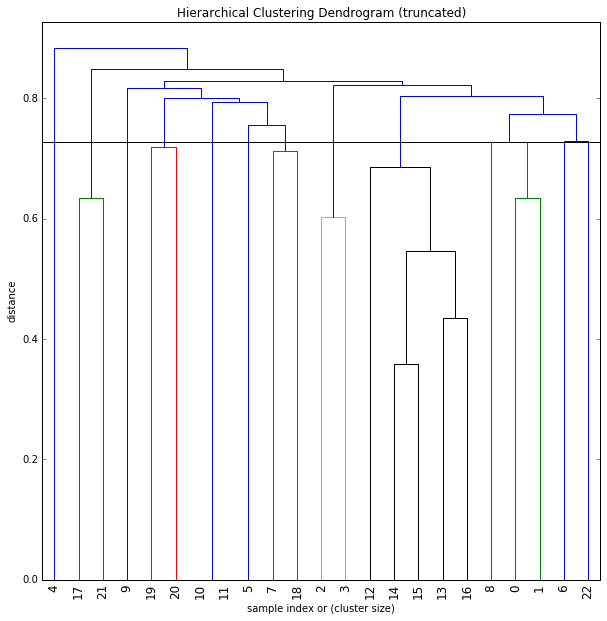

In [13]:
plt.figure(figsize=(10,10))

ddata = fancy_dendrogram(
    Z,
#     labels = df_story.index,
    truncate_mode='lastp',
    p=58,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d = 0.7284 # useful in small plots so annotations don't overlap
)

In [ ]:

last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print "clusters:", k

In [ ]:
class new_model:
    def __init__(self, labels_):
        self.labels_ = labels_
    
reduce_and_plot_clusters(vsm, new_model(clusters))

In [ ]:
Z[:12]